In [1]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time
import tensorflow as tf
import time

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

%matplotlib inline
env = gym.make("Pong-v0")
env.render(mode='rgb_array').shape
env.reset()
print(env.action_space)
env.unwrapped.get_action_meanings()

[2017-11-05 18:05:51,465] Making new env: Pong-v0


Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

[(53, 396), (101, 64), (109, 21056)]
[(53, 132), (101, 16), (109, 5264)]


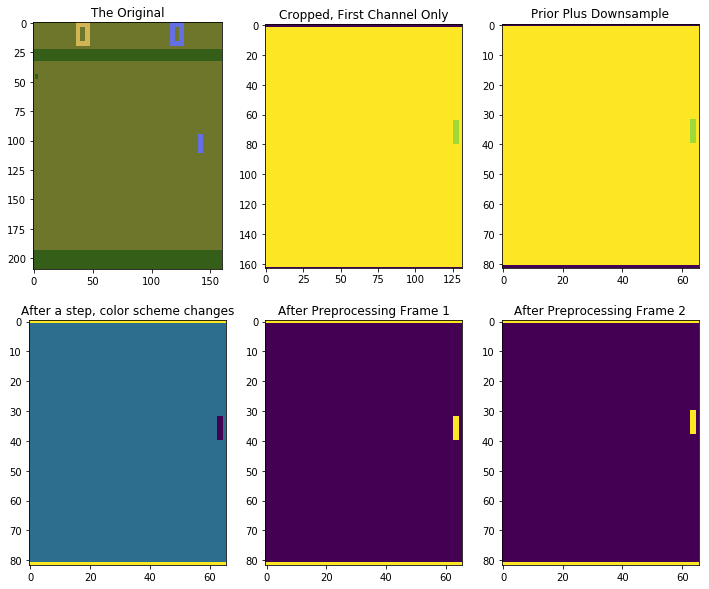

[(92, 16), (144, 5264), (236, 132)]
[(0, 5264), (1, 148)]
[(0, 5264), (1, 148)]


In [2]:
top = 32
bottom = 195
left = 14
right = 146
downsampled_height = int(np.rint((bottom-top)/2))
downsampled_width = int(np.rint((right-left)/2))

def preprocess(img, reshape=False):
    #crop, grab only one channel, and downsample by factor of 2
    img = img[top:bottom,left:right,0][::2,::2]
    #get rid of background color, 109 in first frame, 144 otherwise
    img[np.isin(img,[144,109])] = 0
    img[img!=0] = 1
    if not reshape:
        return img.astype(np.int).ravel()
    else:
        return img.astype(np.int)

def reshape(img):
    return img.reshape(downsampled_height,downsampled_width).astype(np.int)

#what color pixels are in this image?
print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0],return_counts=1))))
print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))

plt.subplots(2,3, figsize=(12,10))

plt.subplot(2,3,1)
plt.title("The Original")
plt.imshow(env.reset())

plt.subplot(2,3,2)
plt.title("Cropped, First Channel Only")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0])

plt.subplot(2,3,3)
plt.title("Prior Plus Downsample")
plt.imshow(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,4)
plt.title("After a step, color scheme changes")
plt.imshow(env.step(2)[0][top:bottom,left:right,0][::2,::2])

plt.subplot(2,3,5)
plt.title("After Preprocessing Frame 1")
plt.imshow(reshape(preprocess(env.reset())))

plt.subplot(2,3,6)
plt.title("After Preprocessing Frame 2")
plt.imshow(reshape(preprocess(env.step(2)[0])))
plt.show()

print(list(zip(*np.unique(env.render(mode='rgb_array')[top:bottom,left:right,0][::2,::2],return_counts=1))))
print(list(zip(*np.unique(reshape(preprocess(env.reset())),return_counts=1))))
print(list(zip(*np.unique(reshape(preprocess(env.render(mode='rgb_array'))),return_counts=1))))


In [3]:
sess = tf.InteractiveSession(config=config)

input_dim = downsampled_height*downsampled_width

x = tf.placeholder(tf.float32, shape=[None, input_dim])
advantage = tf.placeholder(tf.float32, shape=[None, 1])
action = tf.placeholder(tf.int8, shape=[None, 1])
move_down_action = tf.Variable(3, dtype=tf.int8)

h1_dim = 200
l1 = tf.layers.dense(x, h1_dim, activation=tf.nn.relu)
move_down_probability = tf.layers.dense(l1, 1, activation=tf.nn.sigmoid)
#choose reward so gradient wrt action (3=down, 2=up) is correct
sampled_action_log_prob = tf.where(tf.equal(action, move_down_action),
                                     tf.log(move_down_probability),
                                     tf.log(1-move_down_probability))
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
train = optimizer.minimize(tf.reduce_sum(-advantage*sampled_action_log_prob))

In [ ]:
def normalize_rewards(rewards):
    rewards = np.array(rewards)
    mean = np.mean(rewards)
    std_dev = np.std(rewards)
    return (rewards-mean)/std_dev

def play_frame(frame_change):
    p_down = sess.run(move_down_probability,
                feed_dict={x: np.array([frame_change])}).reshape(1)
    #choose an action based on this probability, 3=down, 2=up
    action = np.random.binomial(1, p_down) + 2
    observation, reward, done, info = env.step(action)
    return p_down, action, reward, preprocess(observation), done

def play_game(start_frame):
    discount = 0.99
    reward = 0
    p_list, actions, frames, frame_changes = [], [], [], []
    frames = [start_frame]
    frame_changes.append(frames[-1]-frames[-1])
    while reward==0:
        p_down, action, reward, new_frame, done = play_frame(frame_changes[-1])
        p_list.append(p_down)
        actions.append(action)
        frames.append(new_frame)
        frame_changes.append(frames[-1]-frames[-2])
        if reward:
            rewards = reward * np.array([
                        [discount**k] for k in 
                        range(len(frame_changes)-2,-1,-1)])
    return p_list, actions, frames[:-1], frame_changes[:-1], list(rewards), done
    
def play_match():
    p_list, actions, frames, frame_changes, rewards = [], [], [], [], []
    wins = 0
    games = 0
    env.reset()
    done = 0
    while not done:
        start_frame = preprocess(env.render(mode='rgb_array'))
        prb, act, frm, frm_chng, rwrd, done = play_game(start_frame)
        p_list+=prb
        actions+=act
        frames+=frm
        frame_changes+=frm_chng
        rewards+=rwrd
        wins += max(rwrd[-1][0],0)
        games+=1
    return rewards, frames, frame_changes, actions, p_list, wins, games

def make_batch(n_matches):
    p_list, actions, frames, frame_changes, rewards = [], [], [], [], []
    wins = 0
    games = 0
    for _ in range(n_matches):
        rwrd, frm, frm_chng, act, prb, w, g = play_match()
        p_list+=prb
        actions+=act
        frames+=frm
        frame_changes+=frm_chng
        rewards+=rwrd
        wins += w
        games += g
    rewards = normalize_rewards(rewards)
    return rewards, frames, frame_changes, np.array(actions), p_list, wins, games
    
epochs = 1000

tf.global_variables_initializer().run()

start = time.time()

def concat(one, two):
    return np.concatenate([one,two], axis=1)

norms = [0,0,0,0,0,0,0,0,0,0]
ratios = []
matches_per_batch = 10
watch_games = 0
dynamically_output_quality = 0
            
for i in range(epochs):
    print("Finished {} batches in {} hours, {} norms".format(i, round((time.time()-start)/3600,2), norms))
    norms[i%10] = (i, np.linalg.norm(np.array(
            sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dense_1/kernel:0')))))
    #play Pong with the network, save frames and associated rewards
    reward, frames, frame_changes, actions, p_list, w, g = make_batch(matches_per_batch)
    train.run(feed_dict={x: frame_changes, advantage: np.array(reward), action: actions})
    ratios.append(w/g*100)
    plt.plot(range(1,i+2), ratios)
    plt.xlabel("Batches")
    plt.ylabel("Percent of Games Won")
    plt.savefig("./pong_agent_quality")
    if dynamically_output_quality:
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if i%10==5 and watch_games:
        game = frames
        img = plt.imshow(concat(reshape(game[0]) , reshape(frame_changes[1]))) # only call this once
        for i in range(min(len(game), 200)):
            img.set_data(concat(reshape(game[i]) , reshape(frame_changes[i]))) # just update the data
            plt.title(p_list[i])
            display.clear_output(wait=True)
            display.display(plt.gcf())

Finished 0 batches in 0.0 hours, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] norms
Finished 1 batches in 0.01 hours, [(0, 1.4164246), 0, 0, 0, 0, 0, 0, 0, 0, 0] norms
Finished 2 batches in 0.02 hours, [(0, 1.4164246), (1, 1.4164374), 0, 0, 0, 0, 0, 0, 0, 0] norms
Finished 3 batches in 0.03 hours, [(0, 1.4164246), (1, 1.4164374), (2, 1.4164653), 0, 0, 0, 0, 0, 0, 0] norms
Finished 4 batches in 0.04 hours, [(0, 1.4164246), (1, 1.4164374), (2, 1.4164653), (3, 1.4164947), 0, 0, 0, 0, 0, 0] norms
Finished 5 batches in 0.05 hours, [(0, 1.4164246), (1, 1.4164374), (2, 1.4164653), (3, 1.4164947), (4, 1.4165106), 0, 0, 0, 0, 0] norms
Finished 6 batches in 0.06 hours, [(0, 1.4164246), (1, 1.4164374), (2, 1.4164653), (3, 1.4164947), (4, 1.4165106), (5, 1.4165201), 0, 0, 0, 0] norms
Finished 7 batches in 0.07 hours, [(0, 1.4164246), (1, 1.4164374), (2, 1.4164653), (3, 1.4164947), (4, 1.4165106), (5, 1.4165201), (6, 1.4165103), 0, 0, 0] norms
Finished 8 batches in 0.08 hours, [(0, 1.4164246), (1, 1.4164374), (2

In [ ]:
game = frames
img = plt.imshow(concat(reshape(game[0]) , reshape(frame_changes[1]))) # only call this once
for i in range(min(len(game), 200)):
    img.set_data(concat(reshape(game[i]) , reshape(frame_changes[i]))) # just update the data
    plt.title(p_list[i])
    display.clear_output(wait=True)
    display.display(plt.gcf())